## imports

In [1]:
import __init__
from __init__ import DATA_PATH
from __init__ import PACKAGE_PATH
from dce import DCE
from cluster import Cluster
from descriptor import rdkitDescriptors
import utilities
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


## read data and generate descriptors
* ground_truth using 60% BOD cut
* descriptor using float here

Number of Descriptor:68


(array([756.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 307.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

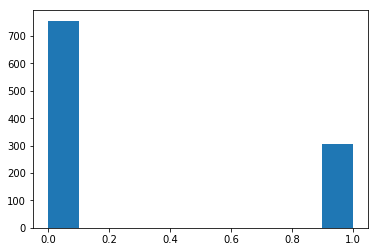

In [42]:
df = pd.read_csv(os.path.join(DATA_PATH,'BOD_RDKit_Descriptors_1063.csv'))
df['cleaned_bod'] = utilities.clean_out_of_bound(df['value (% BOD)'])
feat_float = rdkitDescriptors.batch_compute_all_descriptors(df['SMILES'],desc_type='float')
selected_float_feat = feat_float.loc[:,feat_float.nunique()>1]
print('Number of Descriptor:' + str(len(selected_float_feat.loc[0])))
      
df['bi_class_partition'] = utilities.divide_classes(df['cleaned_bod'], [60])
true_label_biclass = df['bi_class_partition'].values
plt.hist(df['bi_class_partition'])

## build model and train model

In [62]:
autoencoder_dims = [68,55,10]
dce = DCE(autoencoder_dims, n_clusters=2, update_interval=50)
dce.build_model()

In [63]:
dce.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 68)           0                                            
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 68)           272         input[0][0]                      
__________________________________________________________________________________________________
encoder_0 (Dense)               (None, 55)           3795        batch_normalization_12[0][0]     
__________________________________________________________________________________________________
embedding_layer (Dense)         (None, 10)           560         encoder_0[0][0]                  
__________________________________________________________________________________________________
decoder_1 

In [64]:
[y_pred, loss, delta_label] = dce.train_model(selected_float_feat.values,clustering_loss='kld', 
                                              decoder_loss='mse', clustering_loss_weight=0.2)

Epoch: 0
  Total_loss = 0.0045728297;Delta_label = 0.0
  Clustering_loss = 7.30918e-05; Decoder_loss = 0.005697764
Epoch: 50
  Total_loss = 0.0006394975;Delta_label = 0.21636876763875823
  Clustering_loss = 1.6241278e-06; Decoder_loss = 0.0007989658
Epoch: 100
  Total_loss = 0.0005466389;Delta_label = 0.1006585136406397
  Clustering_loss = 5.2951686e-06; Decoder_loss = 0.0006819748
Epoch: 150
  Total_loss = 0.00047142553;Delta_label = 0.06491063029162747
  Clustering_loss = 1.8151872e-05; Decoder_loss = 0.0005847439
Epoch: 200
  Total_loss = 0.00043274803;Delta_label = 0.05079962370649106
  Clustering_loss = 6.565119e-05; Decoder_loss = 0.0005245222
Epoch: 250
  Total_loss = 0.00043138536;Delta_label = 0.03292568203198495
  Clustering_loss = 0.00025784766; Decoder_loss = 0.00047476977
Epoch: 300
  Total_loss = 0.0005589247;Delta_label = 0.024459078080903106
  Clustering_loss = 0.0009912042; Decoder_loss = 0.00045085483
Epoch: 350
  Total_loss = 0.0010399264;Delta_label = 0.063969896519

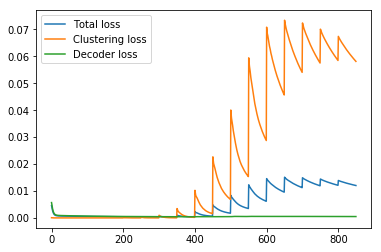

In [67]:
plt.plot(loss[0], label='Total loss')
plt.plot(loss[1], label='Clustering loss')
plt.plot(loss[2], label='Decoder loss')
plt.legend()

Parameter sweeping on loss weight

In [97]:
autoencoder_dims = [68,55,10]
dce = DCE(autoencoder_dims, n_clusters=2, update_interval=50)
dce.build_model()

In [121]:
weight = np.linspace(0.0,1.0,11)
weight

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [122]:
y_pred_list = []
loss_list = []
delta_label_list = []

In [123]:
for i in range(len(weight)):
    dce = DCE(autoencoder_dims, n_clusters=2, update_interval=50)
    dce.build_model()
    [y_pred, loss, delta_label] = dce.train_model(selected_float_feat.values,clustering_loss='kld', 
                                              decoder_loss='mse', clustering_loss_weight=weight[i])
    y_pred_list.append(y_pred)
    loss_list.append(loss)
    delta_label_list.append(delta_label)

Epoch: 0
  Total_loss = 0.013682941;Delta_label = 0.0
  Clustering_loss = 0.00021784329; Decoder_loss = 0.013682941
Epoch: 50
  Total_loss = 0.00080651575;Delta_label = 0.5268109125117592
  Clustering_loss = 3.3970628e-05; Decoder_loss = 0.00080651575
Epoch: 100
  Total_loss = 0.00066166045;Delta_label = 0.05738476011288805
  Clustering_loss = 3.22408e-05; Decoder_loss = 0.00066166045
Epoch: 150
  Total_loss = 0.0005900467;Delta_label = 0.06867356538099718
  Clustering_loss = 3.085343e-05; Decoder_loss = 0.0005900467
Epoch: 200
  Total_loss = 0.0005372006;Delta_label = 0.06679209783631232
  Clustering_loss = 2.9725963e-05; Decoder_loss = 0.0005372006
Epoch: 250
  Total_loss = 0.0005019949;Delta_label = 0.03951081843838194
  Clustering_loss = 2.9116747e-05; Decoder_loss = 0.0005019949
Epoch: 300
  Total_loss = 0.0004731448;Delta_label = 0.043273753527751646
  Clustering_loss = 2.88227e-05; Decoder_loss = 0.0004731448
Epoch: 350
  Total_loss = 0.00045072005;Delta_label = 0.04609595484477

  Total_loss = 0.0002723029;Delta_label = 0.0028222013170272815
  Clustering_loss = 2.0016454e-05; Decoder_loss = 0.0002723029
Epoch: 3000
  Total_loss = 0.00027157902;Delta_label = 0.0009407337723424271
  Clustering_loss = 1.9963392e-05; Decoder_loss = 0.00027157902
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Epoch: 0
  Total_loss = 0.010511441;Delta_label = 0.0
  Clustering_loss = 8.469213e-05; Decoder_loss = 0.011669969
Epoch: 50
  Total_loss = 0.000740158;Delta_label = 0.257761053621825
  Clustering_loss = 1.8104968e-06; Decoder_loss = 0.0008221967
Epoch: 100
  Total_loss = 0.00062482274;Delta_label = 0.09125117591721543
  Clustering_loss = 5.9031704e-06; Decoder_loss = 0.0006935916
Epoch: 150
  Total_loss = 0.00055610604;Delta_label = 0.07808090310442145
  Clustering_loss = 2.0832736e-05; Decoder_loss = 0.0006155809
Epoch: 200
  Total_loss = 0.00049746264;Delta_label = 0.04985888993414864
  Clustering_loss = 7.515581e-05; Decoder_loss = 0.00054438564
Epoch: 250
  

  Clustering_loss = 0.059386432; Decoder_loss = 0.0005771802
Epoch: 950
  Total_loss = 0.017368324;Delta_label = 0.0009407337723424271
  Clustering_loss = 0.056551192; Decoder_loss = 0.0005756661
Epoch: 1000
  Total_loss = 0.016597437;Delta_label = 0.0009407337723424271
  Clustering_loss = 0.053988434; Decoder_loss = 0.0005727234
Epoch: 1050
  Total_loss = 0.015913215;Delta_label = 0.0018814675446848542
  Clustering_loss = 0.051713217; Decoder_loss = 0.00057035603
Epoch: 1100
  Total_loss = 0.01523508;Delta_label = 0.0009407337723424271
  Clustering_loss = 0.04945764; Decoder_loss = 0.00056826853
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Epoch: 0
  Total_loss = 0.0034104893;Delta_label = 0.0
  Clustering_loss = 7.233807e-05; Decoder_loss = 0.0056359232
Epoch: 50
  Total_loss = 0.00047215738;Delta_label = 0.32455315145813735
  Clustering_loss = 6.793265e-07; Decoder_loss = 0.000786476
Epoch: 100
  Total_loss = 0.000380654;Delta_label = 0.11382878645343368
  Clustering

Epoch: 50
  Total_loss = 0.00024806973;Delta_label = 0.2323612417685795
  Clustering_loss = 1.4771183e-07; Decoder_loss = 0.0008265544
Epoch: 100
  Total_loss = 0.0002111075;Delta_label = 0.07243650047036689
  Clustering_loss = 4.7675684e-07; Decoder_loss = 0.0007025792
Epoch: 150
  Total_loss = 0.00019164702;Delta_label = 0.03574788334901223
  Clustering_loss = 1.6902285e-06; Decoder_loss = 0.0006348795
Epoch: 200
  Total_loss = 0.00018116;Delta_label = 0.03292568203198495
  Clustering_loss = 6.3233438e-06; Decoder_loss = 0.00058911217
Epoch: 250
  Total_loss = 0.00018250759;Delta_label = 0.021636876763875823
  Clustering_loss = 2.4866597e-05; Decoder_loss = 0.00055033655
Epoch: 300
  Total_loss = 0.00022612822;Delta_label = 0.016933207902163686
  Clustering_loss = 9.5693955e-05; Decoder_loss = 0.0005304748
Epoch: 350
  Total_loss = 0.00040723415;Delta_label = 0.011288805268109126
  Clustering_loss = 0.00036152682; Decoder_loss = 0.0005138846
Epoch: 400
  Total_loss = 0.0010126383;Del

  Clustering_loss = 0.001028271; Decoder_loss = 0.0070512076
Epoch: 350
  Total_loss = 0.0037471158;Delta_label = 0.004703668861712135
  Clustering_loss = 0.0037471158; Decoder_loss = 0.007162931
Epoch: 400
  Total_loss = 0.011779831;Delta_label = 0.020696142991533398
  Clustering_loss = 0.011779831; Decoder_loss = 0.007473719
Epoch: 450
  Total_loss = 0.02843397;Delta_label = 0.01881467544684854
  Clustering_loss = 0.02843397; Decoder_loss = 0.007755091
Epoch: 500
  Total_loss = 0.048994724;Delta_label = 0.008466603951081843
  Clustering_loss = 0.048994724; Decoder_loss = 0.008569897
Epoch: 550
  Total_loss = 0.06443139;Delta_label = 0.01599247412982126
  Clustering_loss = 0.06443139; Decoder_loss = 0.01086071
Epoch: 600
  Total_loss = 0.07084587;Delta_label = 0.01317027281279398
  Clustering_loss = 0.07084587; Decoder_loss = 0.014415204
Epoch: 650
  Total_loss = 0.07110557;Delta_label = 0.00658513640639699
  Clustering_loss = 0.07110557; Decoder_loss = 0.01800681
Epoch: 700
  Total_l

Total Loss

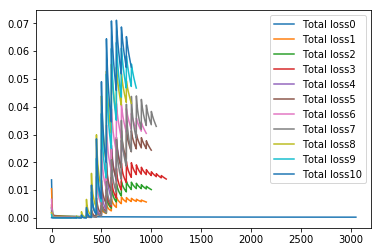

In [126]:
for i in range(len(weight)):
    plt.plot(loss_list[i][0], label='Total loss' + str(i))
plt.legend()

(array([485.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 578.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

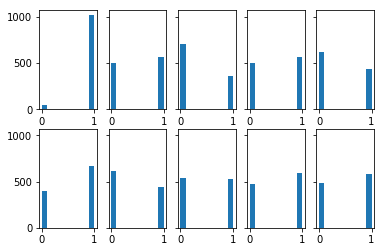

In [143]:
f, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, sharey=True)

ax1.hist(y_pred_list[0])
ax2.hist(y_pred_list[1])
ax3.hist(y_pred_list[2])
ax4.hist(y_pred_list[3])
ax5.hist(y_pred_list[4])
ax6.hist(y_pred_list[5])
ax7.hist(y_pred_list[6])
ax8.hist(y_pred_list[7])
ax9.hist(y_pred_list[8])
ax10.hist(y_pred_list[9])

In [149]:
len(y_pred)

TypeError: object of type 'numpy.int64' has no len()

In [151]:
for i in range(len(weight)):
    Cluster.true_label_metrics(true_label_biclass,y_pred_list[i],print_metric=True)

Metric with True label
adjusted rand score: 0.020995132596429152 
fowlkes_mallows : 0.7416228365218388
Metric with True label
adjusted rand score: 0.029511197792481167 
fowlkes_mallows : 0.5569874809971936
Metric with True label
adjusted rand score: -0.015390953911752403 
fowlkes_mallows : 0.5626628961976219
Metric with True label
adjusted rand score: 0.004453814440613384 
fowlkes_mallows : 0.5452826497525903
Metric with True label
adjusted rand score: 0.0012980238397811306 
fowlkes_mallows : 0.550919503700868
Metric with True label
adjusted rand score: -0.011389872957845779 
fowlkes_mallows : 0.5536811655923655
Metric with True label
adjusted rand score: -0.003194343859552612 
fowlkes_mallows : 0.5480419790245981
Metric with True label
adjusted rand score: 0.0221644913216553 
fowlkes_mallows : 0.5525870424685249
Metric with True label
adjusted rand score: 0.003946771477548625 
fowlkes_mallows : 0.5476525064624934
Metric with True label
adjusted rand score: 0.010846824820350025 
fowlke